#### Loading Files

We have downloaded all NetCDF files available up to June 27, 2022.

Let's demonstrate the staggered nature of the forecasts by opening up the files for March 2, 2024 to March 4, 2022. We use the `parse_tflag` function.

In [1]:
import datetime

def parse_tflag(tflag):
    """
    Return the tflag as a datetime object
    :param list tflag: a list of two int32, the 1st representing date and 2nd representing time
    """
    date = int(tflag[0]) # <1>
    year = date // 1000 # first 4 digits of tflag[0] # <1>
    day_of_year = date % 1000 # last 3 digits of tflag[0] # <1>

    final_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day_of_year - 1) # <2>

    time = int(tflag[1]) # <3>
    hours = time // 10000 # first 2 digits of tflag[1] # <3>
    minutes = (time % 10000) // 100 # 3rd and 4th digits of tflag[1] # <3>
    seconds = time % 100  # last 2 digits of tflag[1] # <3>

    full_datetime = datetime.datetime(year, final_date.month, final_date.day, hours, minutes, seconds) # <4>
    return full_datetime

1. Obtain year and day of year from tflag[0] (date)
2. Create datetime object representing date
3. Obtain hour, mins, and secs from tflag[1] (time)
4. Create final datetime object

In [3]:
files_dir = 'dispersion_files' # <1>
ids = ["BSC18CA12-01", "BSC00CA12-01", "BSC06CA12-01", "BSC12CA12-01"] # <2>
file_names = ['dispersion_20220302.nc', 'dispersion_20220303.nc', 'dispersion_20220304.nc'] # <3>

1. Define the directory location of our files.
2. List of the forecast IDs we use.
3. `file_names` is each file we will open per forecast ID next.

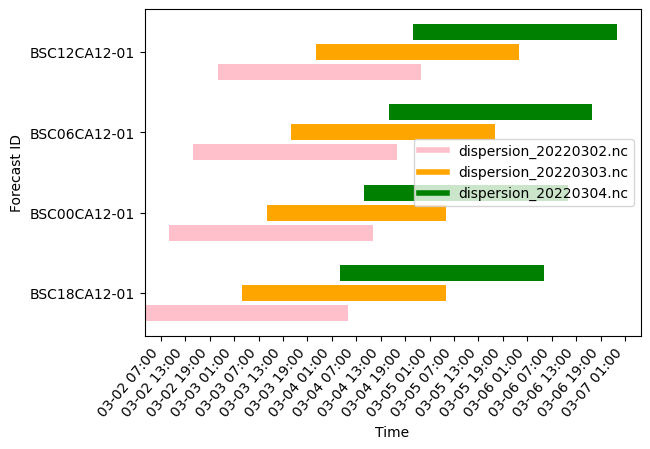

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

fig, ax = plt.subplots()

colors = ['pink', 'orange', 'green']
num_files = len(file_names)
bar_height = 1 / (num_files + 1)  # Dynamic height for the bars

for idx, id_ in enumerate(ids):  # <1>
    for i, f in enumerate(file_names):  # <1>
        curr_file = f'{files_dir}/{id_[3:5]}/{f}'  # <2>
        ds = xr.open_dataset(curr_file)  # <3>
        tflags = ds['TFLAG'].values  # <3>
        
        earliest_time = parse_tflag(tflags[0][0])  # <4>
        latest_time = parse_tflag(tflags[-1][0])  # <4>
        
        # Adjust y position to avoid overlap, using `idx` and `i` to space out bars
        y_position = idx + i * bar_height
        ax.barh(y_position, latest_time - earliest_time, left=earliest_time, 
                height=bar_height * 0.8, color=colors[i])  # <5>

# Adjust y-axis to display ID labels in a way that matches the bar positions
ax.set_yticks([i + (num_files - 1) * bar_height / 2 for i in range(len(ids))])
ax.set_yticklabels(ids)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
fig.autofmt_xdate(rotation=50)

ax.set_xlabel("Time")
ax.set_ylabel("Forecast ID")
# ax.set_title("Smoke Predictions per Forecast ID per File, for 03/02/22-03/05/22")

legend_elements = [Line2D([0], [0], linewidth=4, color=colors[i], label=file_names[i]) for i in range(3)]
ax.legend(handles=legend_elements, loc='center right')

# plt.show()
plt.savefig('overlaps.png', bbox_inches="tight")


1. Open each file for each forecast ID.
2. Create the path string.
3. Open the file with `xarray` and get the TFLAG values.
4. Get the earliest and latest available time flags.
5. Plot the time range represented with the time flags as a horizontal bar.

The 6 loaded files cover the time ranges shown above. 

Notice, for any given hour, there can be various predictions available to choose from. For example, for 2022-03-04 01:00, we can find it represented in `dispersion_20220303.nc` across all forecast IDs.

Given that these predictions are forecasts, we run on the assumption that the earliest available predictions per file are the most accurate.

Therefore, for example, if we want to choose the most accurate PM2.5 prediction for 2022-03-04 01:00 we would load the prediction with the BSC12CA12-01 forecast ID.

For further details on how we load the best prediction for every hour of the dataset, see @sec-sequencing.